## Neural networks for segmentation

This is an __alternative assignment__ meaning that you can do it __instead of the main one__!

In [1]:
! wget -nc https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=1 -O data.zip
! unzip -n data.zip

--2024-10-10 06:07:00--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/3vobs80wbzvjhz4lzsg46/data.zip?rlkey=9dxrxyzv549osxdubvodinoea&dl=1 [following]
--2024-10-10 06:07:00--  https://www.dropbox.com/scl/fi/3vobs80wbzvjhz4lzsg46/data.zip?rlkey=9dxrxyzv549osxdubvodinoea&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b5aa2b877b6e433c2509c013b.dl.dropboxusercontent.com/cd/0/inline/CcJB8_39yyQWrC4_nGLY7syyIur5gBpA8ChAFWqzsx9qYFwk87fLGZEG9O8eVdutfWmEOcSTocACCqQZQgqgdKnHBK0jEKAjXhJxLGVyThyYD_NloLMIOQps6NrLsDKx0AE/file?dl=1# [following]
--2024-10-10 06:07:01--  https://uc3b5aa2b877b6e433c2509c013b.dl.dropboxusercontent.com/cd/0/inline/CcJB8_39yyQWrC

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import imageio

<ipython-input-3-77b7120ec2b5>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
<ipython-input-3-77b7120ec2b5>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread('BBBC018_v1_outlines/train/00735-cells.png')


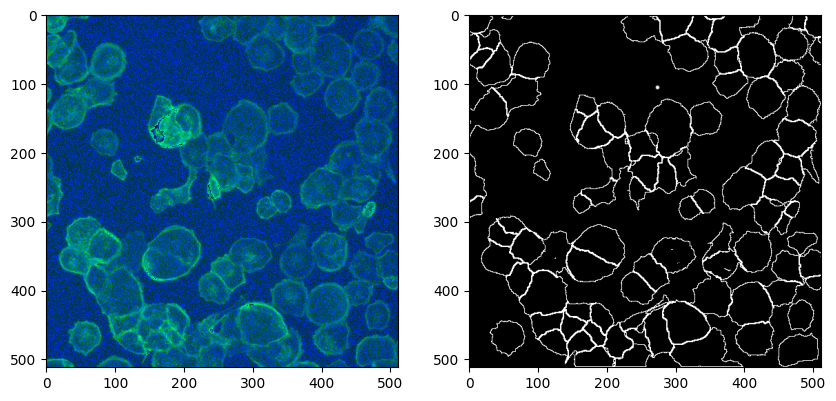

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imageio.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [96]:
import matplotlib.pyplot as plt
import torch

def plot_samples(data_loader, num_samples=4):
    images, labels = next(iter(data_loader))

    images = images.numpy().transpose(0, 2, 3, 1)  # Change shape to (N, H, W, C)
    labels = labels.numpy()

    fig, axs = plt.subplots(2, num_samples, figsize=(3 * num_samples, 6))

    for i in range(num_samples):
        axs[0, i].imshow(images[i])
        axs[0, i].set_title("Image")

        # Plot the mask
        axs[1, i].imshow(labels[i], 'gray')
        axs[1, i].set_title("Mask")

    plt.tight_layout()
    plt.show()


In [68]:
def compute_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in dataloader:
        images = images.cpu().numpy().astype(np.float32) / 255.0  # Scale to [0, 1]

        flattened_images = images.reshape(images.shape[0], -1)

        mean += np.mean(flattened_images)
        std += np.std(flattened_images)
        total_images += images.shape[0]

    overall_mean = mean / total_images
    overall_std = std / total_images

    return overall_mean, overall_std


In [6]:
import os
import cv2

class SegmentationDataset():
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
      return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_filename = f"{self.image_filenames[idx].split('-')[0]}-cells.png"
        mask_name = os.path.join(self.masks_dir, mask_filename)

        image = cv2.imread(image_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)

            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [80]:
dataset = SegmentationDataset(images_dir='/content/BBBC018_v1_images-fixed/train', masks_dir='/content/BBBC018_v1_outlines/train')
loader = DataLoader(dataset=train_dataset, batch_size=4)

mean, std = compute_mean_std(loader)

In [111]:
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True

In [101]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.RandomResizedCrop(width=IMAGE_HEIGHT, height=IMAGE_WIDTH, scale=(0.3, 1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.5),
    A.RandomGridShuffle(grid=(2, 2), p=0.2),
    A.ColorJitter(),
    #A.Normalize(mean=[mean], std=[std]),
    A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
    ToTensorV2(),
])

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )


In [103]:
train_dataset = SegmentationDataset(images_dir='/content/BBBC018_v1_images-fixed/train', masks_dir='/content/BBBC018_v1_outlines/train', transform=train_transforms)
val_dataset = SegmentationDataset(images_dir='/content/BBBC018_v1_images-fixed/val', masks_dir='/content/BBBC018_v1_outlines/val', transform=val_transforms)

In [104]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)

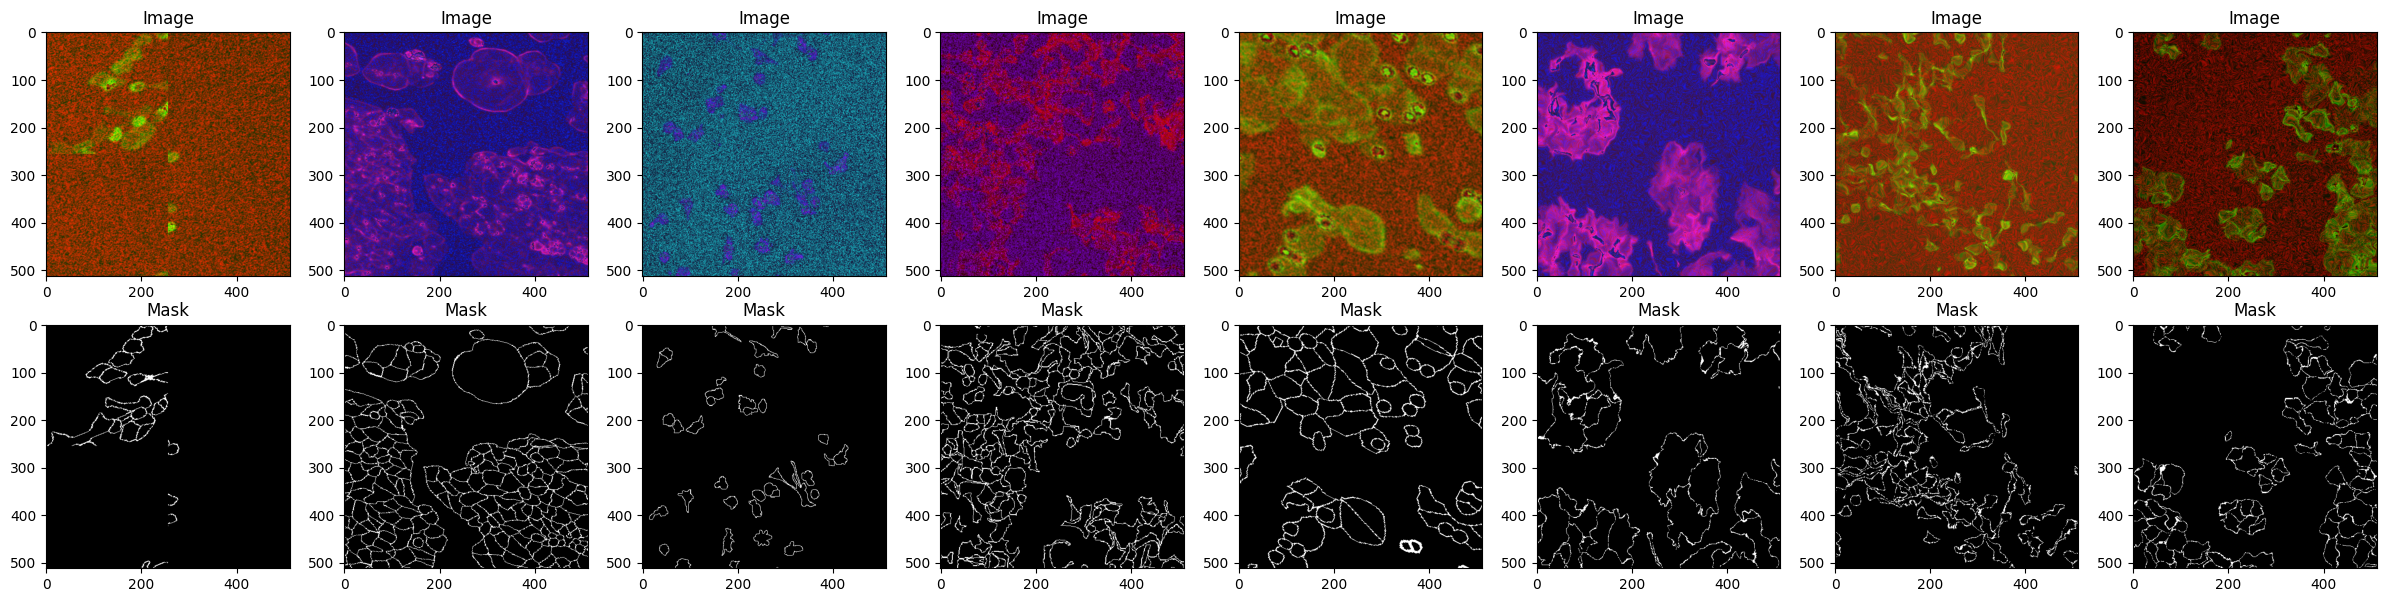

In [105]:
plot_samples(train_loader, 8)

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now:
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures.

Good luck!

In [45]:
compute_mean_std(train_loader)

(3.226071930297776, 2.947986849944375)

In [106]:
# calculate class imbalance in masks
images, masks = next(iter(train_loader))
binary_masks = (masks.numpy() > 0).astype(np.float32)
total_pixels = binary_masks.size
edge_pixels = np.sum(binary_masks)

edge_weights = 1 - edge_pixels/total_pixels

In [124]:
# define loss

def calc_iou_unbiased(prediction, ground_truth, edge_weights):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()# * edge_weights
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()# * edge_weights

    return float(intersection) / union * edge_weights

In [122]:
# define model

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [123]:
def train_fn(loader, model, optimizer, criterion, scaler):
    model.train()
    val_running_loss = 0
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = criterion(predictions, targets)

        val_running_loss += loss.item() * BATCH_SIZE
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    val_loss = val_running_loss / (batch_idx+1)

In [119]:
def val_fn(model, dataloader, criterion, optimizer):
    model.eval()
    val_running_loss = 0
    loop = tqdm(loader)

    with torch.no_grad():
        for batch_idx , (data, targets) in enumerate(loop):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = criterion(predictions, targets)

            y_pred = model(img)
            loss = criterion(y_pred,mask)

            val_running_loss += loss.item() * BATCH_SIZE
            loop.set_postfix(loss=loss.item())

        val_loss = val_running_loss / (batch_idx+1)

    return val_loss

In [126]:
from torch import optim

In [128]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = calc_iou_unbiased
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-128-f8bc53b2b077>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
